# Compression with Tensor decomposition

In the previous tutorial, we have gone over tensor decomposition, specifically CP and Tucker.
We will now apply these to a concrete example, to compress an image.

Let's first load the required imports:

In [1]:
import tensorly as tl
import numpy as np
from scipy.misc import face

import matplotlib.pyplot as plt
%matplotlib inline

random_state = 12345

Using mxnet backend.


As input image, we will use that returned by the face function, which simply loads a 1024 x 768, color image of a raccoon face.

In [2]:
image = tl.tensor(face(), dtype='float64')

By calling tl.tensor we have converted the image into a tensor of type that of the selected backend (MXNet by default):

In [3]:
type(image)

mxnet.ndarray.NDArray

Our image is a small tensor of size (height, width, n_channels), where n_channels=3 and corresponds to the colors (Red, Green, Blue):

In [4]:
image.shape

(768, 1024, 3)

Note that by default, tensors are of type float, rather than uint8 to allow for efficient calculation:

In [5]:
image.dtype

numpy.float64

Let's visualise the image: we first define a convenience function to convert back images in the float format to uint8 (the expected type for images).

In [6]:
def to_image(tensor):
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

And the actual plotting:

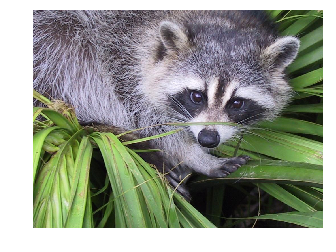

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_off()
ax.imshow(to_image(image))

## Parafac (CP) decomposition

In [8]:
from tensorly.decomposition import parafac

The decomposition has one important parameter: the rank of the decomposition.

In [9]:
cp_rank = 50

In [10]:
factors = parafac(image, rank=cp_rank, init='random', tol=10e-6)

I use random initialization here since it is faster and SVD is *not yet* implemented in MXNet.

Let's check the size of each factor:

In [11]:
[factor.shape for factor in factors]

[(768, 50), (1024, 50), (3, 50)]

Now let's reconstruct the original image from the factors:

In [12]:
cp_reconstruction = tl.kruskal_to_tensor(factors)

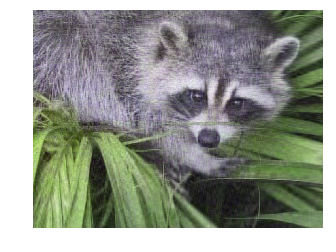

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_off()
ax.imshow(to_image(cp_reconstruction))

However this is a little inefficient, in this case, as we are compressing each dimension to the same rank (including the last dimension, which, from 3 is encoded to 50!). Tucker can be seen as a generalization of this and will allow us to have a more efficient compression and specify a different rank for each dimension (specifically, CP can be thought of as a Tucker decomposition with a super-diagonal core tensor).

## Tucker decomposition

Now let's compress the image using Tensor decomposition:

In [14]:
from tensorly.decomposition import tucker
from math import ceil

We will use a core tensor of approximately half the size:

In [15]:
[ceil(i/3) for i in image.shape]

[256, 342, 1]

Let's ignore that actually and set these ranks:

In [16]:
tucker_rank = [100, 100, 2]

We perform Tucker decomposition, as easy as a function call:

In [17]:
core, tucker_factors = tucker(image, ranks=tucker_rank, init='random', tol=10e-5, random_state=random_state)

Now let's reconstruct the image from the compressed version and plot it:

In [18]:
tucker_reconstruction = tl.tucker_to_tensor(core, tucker_factors)

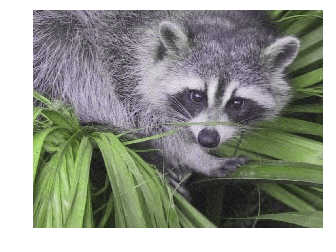

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_off()
ax.imshow(to_image(tucker_reconstruction))

# Compression ratio 

In [20]:
def cp_params(rank, input_shape):
    """Computes the number of parameters of a CP decomposition
    
    Parameters
    ----------
    rank : int
        rank of the CP decomposition
    input_shape : int tuple
        shape of the input image
        
    Returns
    -------
    int : number of parameters of the decomposed tensor in the Kruskal form
    """
    return sum([rank*i for i in input_shape])

In [21]:
def tucker_params(rank, input_shape):
    """Computes the number of parameters of a Tucker decomposition
    
    Parameters
    ----------
    rank : int tuple
        rank of the Tucker decomposition
        (i.e. size of the core tensor)
    input_shape : int tuple
        shape of the input image
        
    Returns
    -------
    int : number of parameters of the decomposed tensor in the Tucker form
    """
    factor_params = sum([r*s for (r, s) in zip(rank, input_shape)])
    core_params = np.prod(rank)
    return core_params + factor_params

In [22]:
def space_savings(uncompressed_params, compressed_params):
    """Returns the space savings
    
        Given the number of parameters of the uncompressed and compressed models, 
        returns the space savings, in percentage
    """
    return int(100*(1 - compressed_params/uncompressed_params))

In [23]:
original_params = np.prod(image.shape)

n_cp = cp_params(cp_rank, image.shape)
save_cp = space_savings(original_params, n_cp)
n_tucker = tucker_params(tucker_rank, image.shape)
save_tucker = space_savings(original_params, n_tucker)

print('{} original params, CP: {} params, Tucker: {} params'.format(original_params, n_cp, n_tucker))
print('Space savings: CP:{}%, Tucker:{}%'.format(save_cp, save_tucker))


2359296 original params, CP: 89750 params, Tucker: 199206 params
Space savings: CP:96%, Tucker:91%


As you can see, the space savings are not as large with the Tucker decomposition as we need to store, in addition to the factors of the decomposition, the core tensor. In the case of the CP decomposition there is no core tensor (it is actually a super-diagonal core tensor, the values of which are absorbed in the factors of the decomposition).

# Conclusion

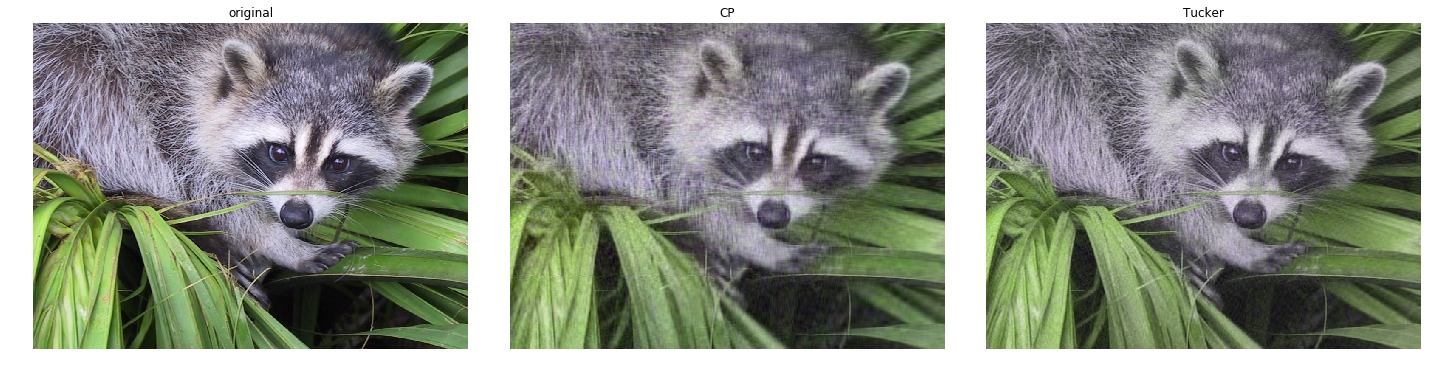

In [24]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 3, 1)
ax.set_axis_off()
ax.imshow(to_image(image))
ax.set_title('original')

ax = fig.add_subplot(1, 3, 2)
ax.set_axis_off()
ax.imshow(to_image(cp_reconstruction))
ax.set_title('CP')

ax = fig.add_subplot(1, 3, 3)
ax.set_axis_off()
ax.imshow(to_image(tucker_reconstruction))
ax.set_title('Tucker')

plt.tight_layout()